# Importation des packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.stats.mstats import winsorize

# Importation des datasets

In [3]:
female_players = pd.read_csv("../Data/female_players.csv", engine="pyarrow")
#male_players = pd.read_csv("../Data/male_players.csv", engine="pyarrow")

In [4]:
female_players.head()

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,227125,/player/227125/sam-kerr/230009,23,9,2023-01-13,S. Kerr,Samantha May Kerr,ST,91,91,...,62+3,62+3,64+3,61+3,58+3,58+3,58+3,61+3,20+3,https://cdn.sofifa.net/players/227/125/23_120.png
1,227316,/player/227316/wendie-renard/230009,23,9,2023-01-13,W. Renard,Wéndèleine Thérèse Renard,CB,91,91,...,87+3,87+3,80+3,82+3,91,91,91,82+3,21+3,https://cdn.sofifa.net/players/227/316/23_120.png
2,226301,/player/226301/alex-morgan/230009,23,9,2023-01-13,A. Morgan,Alexandra Morgan Carrasco,ST,90,90,...,67+3,67+3,69+3,66+3,60+3,60+3,60+3,66+3,19+3,https://cdn.sofifa.net/players/226/301/23_120.png
3,227310,/player/227310/ada-hegerberg/230009,23,9,2023-01-13,A. Hegerberg,Ada Martine Stolsmo Hegerberg,ST,90,91,...,61+3,61+3,63+3,60+3,56+3,56+3,56+3,60+3,20+3,https://cdn.sofifa.net/players/227/310/23_120.png
4,227246,/player/227246/lucy-bronze/230009,23,9,2023-01-13,L. Bronze,Lucia Roberta Tough Bronze,RB,89,89,...,86+3,86+3,87+2,87+2,87+2,87+2,87+2,87+2,20+3,https://cdn.sofifa.net/players/227/246/23_120.png


# 1. Exploration et préparation des données :

* *Exploration initiale* : analyser la structure du jeu de données (nombre de variables, types :
numériques / catégorielles).

* *Nettoyage des données* :
  – Gestion des valeurs manquantes (imputation par la moyenne/médiane ou suppression s’il
  y en a peu).
  – Identification et traitement d’éventuels outliers (ex: valeurs de performance totalement
  irréalistes) :
    * *Option 1* : suppression si le nombre d’outliers est faible.
    * *Option 2* : Winsorisation (ramener à un quantile limite).

* *Gestion des variables catégorielles (poste)* :
  – **Encodage One-Hot** pour inclure le poste dans l’ACP comme variable numérique (ex.:
  défenseur = [0,1,0,0], milieu = [0,0,1,0], etc.).
  – *Alternatives* :
    * Exclure le poste si on souhaite une ACP strictement sur des données quantitatives.
    * Ou utiliser une *Analyse des Correspondances Multiples* (ACM) dédiée aux variables
    qualitatives (mais c’est hors champ ACP "classique").

* *Sélection des variables numériques* : buts, passes décisives, tacles, dribbles, âge, etc.

* *Normalisation / Standardisation* :
  – **Choix recommandé** : Z-score (centrer-réduire) pour chaque variable :

$$z = \frac{x - \mu}{\sigma}$$
  

  – *Justification* : adaptée en présence de valeurs extrêmes modérées, et rend chaque variable d’égale importance dans l’ACP.

In [5]:
print("Female players:")
display(female_players.head())

#print("Male players:")
#display(male_players.head())

print("Informations sur female_players:")
female_players.info()

print("Statistiques descriptives sur female_players:")
display(female_players.describe(include="all"))

# print("Informations sur male_players:")
# male_players.info()

# print("Statistiques descriptives sur male_players:")
# display(male_players.describe(include="all"))

Female players:


,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,227125,/player/227125/sam-kerr/230009,23,9,2023-01-13,S. Kerr,Samantha May Kerr,ST,91,91,...,62+3,62+3,64+3,61+3,58+3,58+3,58+3,61+3,20+3,https://cdn.sofifa.net/players/227/125/23_120.png
1,227316,/player/227316/wendie-renard/230009,23,9,2023-01-13,W. Renard,Wéndèleine Thérèse Renard,CB,91,91,...,87+3,87+3,80+3,82+3,91,91,91,82+3,21+3,https://cdn.sofifa.net/players/227/316/23_120.png
2,226301,/player/226301/alex-morgan/230009,23,9,2023-01-13,A. Morgan,Alexandra Morgan Carrasco,ST,90,90,...,67+3,67+3,69+3,66+3,60+3,60+3,60+3,66+3,19+3,https://cdn.sofifa.net/players/226/301/23_120.png
3,227310,/player/227310/ada-hegerberg/230009,23,9,2023-01-13,A. Hegerberg,Ada Martine Stolsmo Hegerberg,ST,90,91,...,61+3,61+3,63+3,60+3,56+3,56+3,56+3,60+3,20+3,https://cdn.sofifa.net/players/227/310/23_120.png
4,227246,/player/227246/lucy-bronze/230009,23,9,2023-01-13,L. Bronze,Lucia Roberta Tough Bronze,RB,89,89,...,86+3,86+3,87+2,87+2,87+2,87+2,87+2,87+2,20+3,https://cdn.sofifa.net/players/227/246/23_120.png


Informations sur female_players:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181361 entries, 0 to 181360
Columns: 110 entries, player_id to player_face_url
dtypes: float64(18), int64(45), object(47)
memory usage: 152.2+ MB
Statistiques descriptives sur female_players:


,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
count,181361.000000,181361,181361.000000,181361.000000,181361,181361,181361,181361,181361.000000,181361.000000,...,181361,181361,181361,181361,181361,181361,181361,181361,181361,181361
unique,NaN,181361,NaN,NaN,512,1690,1654,382,NaN,NaN,...,287,287,274,274,295,295,295,274,137,4131
top,NaN,/player/227125/sam-kerr/230009,NaN,NaN,2022-09-28,L. Williams,Samantha May Kerr,GK,NaN,NaN,...,69+1,69+1,71+2,71+1,71+1,71+1,71+1,71+1,18+2,https://cdn.sofifa.net/players/227/112/17_120.png
freq,NaN,1,NaN,NaN,835,543,519,22735,NaN,NaN,...,3693,3693,3502,3725,3140,3140,3140,3725,15184,99
mean,234662.993907,NaN,19.223538,36.727703,NaN,NaN,NaN,NaN,76.269909,79.672967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,10659.745380,NaN,2.060414,23.555409,NaN,NaN,NaN,NaN,5.709719,5.422202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,226177.000000,NaN,16.000000,1.000000,NaN,NaN,NaN,NaN,49.000000,49.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,227117.000000,NaN,17.000000,16.000000,NaN,NaN,NaN,NaN,72.000000,76.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,227586.000000,NaN,19.000000,35.000000,NaN,NaN,NaN,NaN,76.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,241226.000000,NaN,21.000000,54.000000,NaN,NaN,NaN,NaN,80.000000,83.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**-> Nous avons décidé de nous concentrer sur le dataset `female_players` étant donné que le dataset est + petit et cela nous permet de ne pas avoir besoin d'un ordinateur trop puissant pour l'analyse que nous allons faire**

In [ ]:
# Imputation pour les variables numériques par la médiane
numeric_cols = female_players.select_dtypes(include=["int64", "float64"]).columns

for col in numeric_cols:
    median_val = female_players[col].median()
    female_players[col].fillna(median_val, inplace=True)

# Imputation pour les variables catégorielles par la modalité la plus fréquente
categorical_cols = female_players.select_dtypes(include=["object"]).columns

for col in categorical_cols:
    mode_val = female_players[col].mode()[0]
    female_players[col].fillna(mode_val, inplace=True)

# verif après imputation
print("Après imputation - infos:")
female_players.info()

/var/folders/vf/qcsfk0590zj_zrqnrs3xwnxr0000gn/T/ipykernel_5674/2564233567.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  female_players[col].fillna(median_val, inplace=True)
/var/folders/vf/qcsfk0590zj_zrqnrs3xwnxr0000gn/T/ipykernel_5674/2564233567.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

Après imputation - infos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181361 entries, 0 to 181360
Columns: 110 entries, player_id to player_face_url
dtypes: float64(18), int64(45), object(47)
memory usage: 152.2+ MB


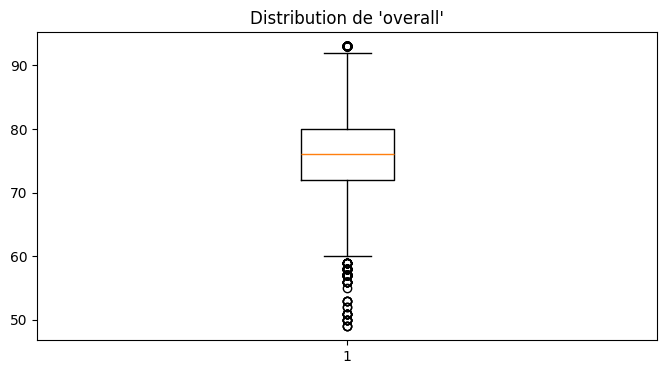

Taille du dataset après suppression des outliers: (166296, 111)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import winsorize

# Affichage d'un boxplot pour visualiser la distribution de 'overall'
plt.figure(figsize=(8,4))
plt.boxplot(female_players["overall"])
plt.title("Distribution de 'overall'")
plt.show()

# Option 1 : Suppression des outliers
lower_bound = female_players["overall"].quantile(0.05)
upper_bound = female_players["overall"].quantile(0.95)
female_players = female_players[(female_players["overall"] >= lower_bound) & (female_players["overall"] <= upper_bound)]
print("Taille du dataset après suppression des outliers:", female_players.shape)

In [10]:
# Option 2 : Winsorisation de 'overall'
female_players["overall_winsor"] = winsorize(female_players["overall"], limits=[0.05, 0.05])
print("Exemple d'overall avant et après winsorisation:")
display(female_players[["overall", "overall_winsor"]].head())

Exemple d'overall avant et après winsorisation:


,overall,overall_winsor
0,91,86
1,91,86
2,90,86
3,90,86
4,89,86


**-> nous avons choisi l'option 1**

In [ ]:
# Transformer chaque valeur en liste de positions (en supprimant les espaces inutiles)
positions_split = female_players["player_positions"].apply(lambda x: [pos.strip() for pos in x.split(",")])

# Créer l'encodeur multi-label
mlb = MultiLabelBinarizer()

# Appliquer l'encodage et créer un dataframe: dont l'index correspond à celui du dataset original
positions_encoded = pd.DataFrame(mlb.fit_transform(positions_split),
                                 columns=mlb.classes_,
                                 index=female_players.index)

# joidnre les new  colonnes au dataset original
female_players = female_players.join(positions_encoded, rsuffix="_encoded")

# Affichage des nouvelles colonnes 
print("Exemple des positions encodées :")
display(female_players[mlb.classes_].head())

Exemple des positions encodées :


,CAM,CB,CDM,CF,CM,GK,LB,LM,LW,LWB,RB,RM,RW,RWB,ST
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [13]:
# Sélectionner les variables numériques pertinentes pour l'ACP
variables_acp = [
    "overall", "potential", "value_eur", "wage_eur", "age",
    "height_cm", "weight_kg", "pace", "shooting", "passing",
    "dribbling", "defending", "physic"
]

# Extraire le sous-dataset
data_acp = female_players[variables_acp]

# Afficher un résumé descriptif pour vérifier la sélection
print("Statistiques descriptives du sous-dataset pour l'ACP :")
display(data_acp.describe())

Statistiques descriptives du sous-dataset pour l'ACP :


,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,pace,shooting,passing,dribbling,defending,physic
count,181361.000000,181361.000000,1.813610e+05,181361.000000,181361.000000,181361.000000,181361.000000,181361.000000,181361.000000,181361.000000,181361.000000,181361.000000,181361.000000
mean,76.269909,79.672967,6.771268e+06,703.156687,26.014099,168.756464,61.213580,73.477225,61.204868,65.755399,70.953193,59.139236,68.295273
std,5.709719,5.422202,4.284602e+06,78.791209,3.907456,6.249204,5.563279,8.488283,15.715096,10.001192,9.466929,19.060001,8.694182
min,49.000000,49.000000,3.250000e+05,500.000000,16.000000,150.000000,45.000000,30.000000,20.000000,26.000000,30.000000,16.000000,34.000000
25%,72.000000,76.000000,6.500000e+06,700.000000,23.000000,164.000000,57.000000,69.000000,51.000000,60.000000,67.000000,42.000000,63.000000
50%,76.000000,80.000000,6.500000e+06,700.000000,26.000000,170.000000,61.000000,74.000000,65.000000,67.000000,73.000000,66.000000,69.000000
75%,80.000000,83.000000,6.500000e+06,700.000000,29.000000,173.000000,65.000000,79.000000,73.000000,72.000000,77.000000,74.000000,74.000000
max,93.000000,95.000000,1.735000e+08,4000.000000,41.000000,188.000000,84.000000,96.000000,93.000000,93.000000,93.000000,93.000000,89.000000


In [15]:
scaler = StandardScaler()

# Appliquer la standardisation aux variables sélectionnées pour l'ACP
data_acp_scaled = scaler.fit_transform(data_acp)

# Convertir le résultat en DataFrame pour faciliter la lecture
data_acp_scaled = pd.DataFrame(data_acp_scaled, columns=data_acp.columns)

print("Aperçu des données standardisées (ACP):")
display(data_acp_scaled.head())

Aperçu des données standardisées (ACP):


,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,pace,shooting,passing,dribbling,defending,physic
0,2.579835,2.089015,29.811189,41.842896,0.508235,-0.121050,0.860362,1.593115,1.895961,0.824364,2.011936,-0.899228,1.691334
1,2.579835,2.089015,19.308435,29.151090,1.276000,2.919346,1.579364,-1.234320,0.686929,0.524399,0.110575,1.776540,2.151413
2,2.404694,1.904588,-0.063312,-0.040064,1.531922,-0.121050,0.141360,1.828735,1.895961,1.424294,1.800674,-0.636898,1.001216
3,2.404694,2.089015,31.795043,29.151090,-0.003608,1.159117,1.219863,1.121876,1.895961,1.124329,1.695043,-1.056626,1.001216
4,2.229554,1.720161,-0.063312,-0.040064,1.020079,0.359013,0.680611,1.357496,1.005096,1.624271,1.272518,1.514210,2.381453


# 2. Analyse en Composantes Principales (ACP) :

• *Calcul et interprétation* :
  – Construire la **matrice de corrélation** des variables normalisées.
  – Déterminer le nombre optimal de composantes via le **scree plot** (critère d’éboulement),
  et éventuellement le **critère de Kaiser** (valeurs propres > 1).

• *Cercle de corrélation* :
  – Représenter les variables dans le plan des deux premières composantes.
  – Ajouter un **tableau de contributions** des variables pour chaque axe (afin de justifier
  l’étiquette “Axe 1 = Attaque vs Défense”, par exemple).
  – Éviter la surcharge en sélectionnant les variables les plus contributives (top 10).

• *Plan factoriel des individus (joueurs)* :
  – Projeter les joueurs sur les deux premiers axes et identifier des regroupements (attaquants,
  défenseurs, etc.).
  – **Biplots** : combiner la représentation des variables et des individus pour visualiser simul-
  tanément leurs relations.
  – **Colorer** les joueurs selon leur poste (variable catégorielle) pour voir si les groupes se
  distinguent.

• *Suggestion avancée : Clustering sur les composantes* :
  – Appliquer **K-Means** sur les composantes retenues (ex : 2 ou 3 axes).
  – **Validation** : utiliser la **méthode du coude** et/ou le **score de silhouette** pour déter-
  miner le nombre optimal de clusters et vérifier la robustesse de la segmentation.

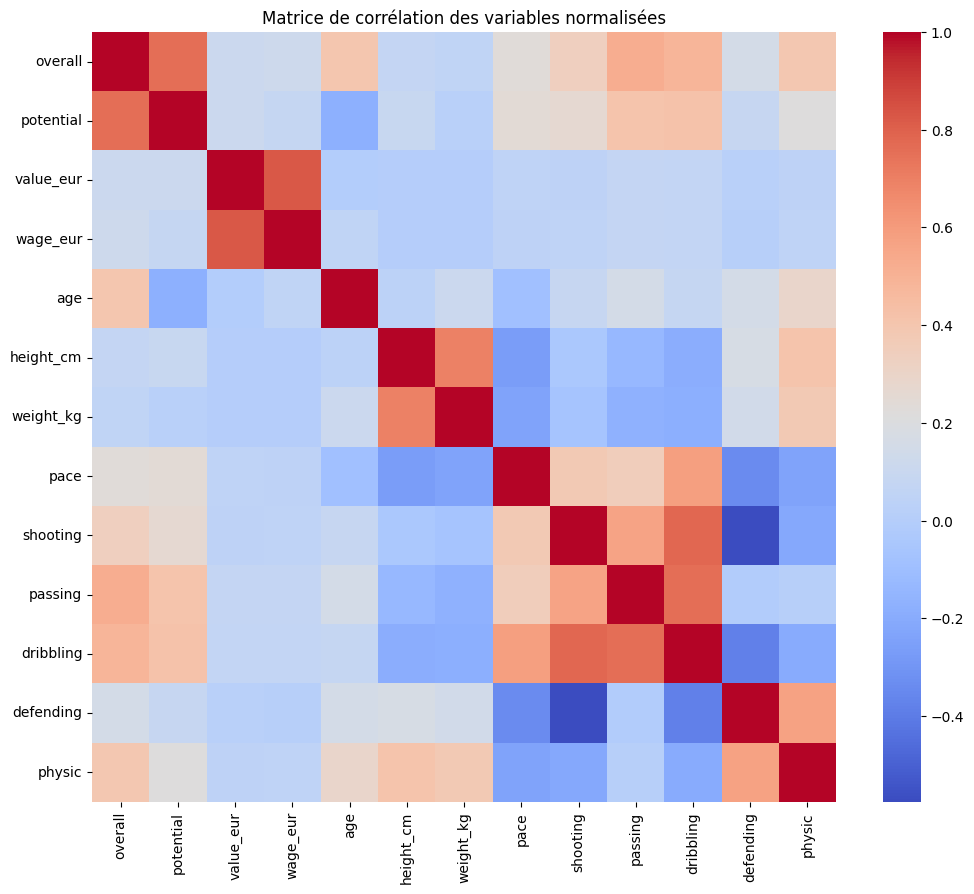

In [16]:
corr_matrix = data_acp_scaled.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Matrice de corrélation des variables normalisées")
plt.show()


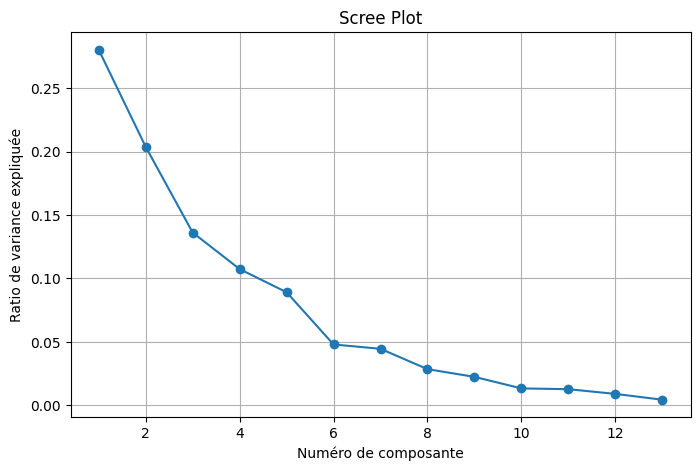

Nombre de composantes retenues selon le critère de Kaiser : 5


In [ ]:
# Calcul de l'ACP sur l'ensemble des données standardisées
pca = PCA()
pca.fit(data_acp_scaled)
explained_variance = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

# Scree Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel("Numéro de composante")
plt.ylabel("Ratio de variance expliquée")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

# Critère de Kaiser : nombre d'éigenvalues > 1
num_components_kaiser = sum(eigenvalues > 1)
print("Nombre de composantes retenues selon le critère de Kaiser :", num_components_kaiser)


Top 10 contributions pour Composante 1 :


,Composante 1,Composante 2
dribbling,0.236249,0.000037
shooting,0.174019,0.001207
passing,0.164525,0.020654
pace,0.120456,0.015966
overall,0.094855,0.173133
potential,0.080037,0.089585
defending,0.049098,0.124481
weight_kg,0.026684,0.108399
height_cm,0.023979,0.122682
physic,0.014886,0.247602



Top 10 contributions pour Composante 2 :


,Composante 1,Composante 2
physic,0.014886,0.247602
overall,0.094855,0.173133
defending,0.049098,0.124481
height_cm,0.023979,0.122682
weight_kg,0.026684,0.108399
potential,0.080037,0.089585
age,0.001082,0.057908
passing,0.164525,0.020654
wage_eur,0.007013,0.019933
value_eur,0.007118,0.018413


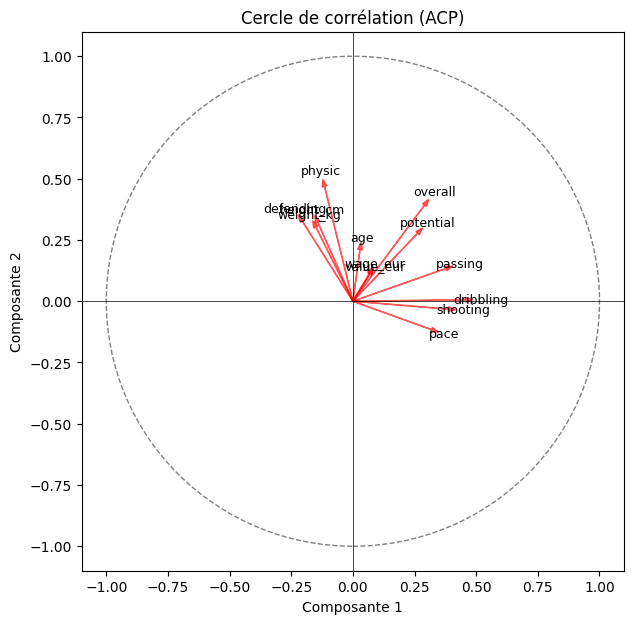

In [ ]:
# PCA avec le nombre de composantes retenues
pca_2 = PCA(n_components=5)
pca_2.fit(data_acp_scaled)

# Loadings (coefficients) : shape = (nb_variables, nb_axes)
loadings = pca_2.components_.T  # transposé pour avoir les variables en lignes
axes_labels = [f"Composante {i+1}" for i in range(pca_2.n_components_)]

# Contributions : carré des loadings
contrib = loadings**2
contrib_df = pd.DataFrame(contrib, 
                          index=data_acp_scaled.columns,
                          columns=axes_labels)

# Top 10 contributions pour chaque axe
for i, col in enumerate(contrib_df.columns):
    print(f"\nTop 10 contributions pour {col} :")
    display(contrib_df.sort_values(col, ascending=False).head(10))

# Sélection des variables les plus contributives (ex : top 10 sur l'un ou l'autre axe)
top_vars_axis1 = contrib_df.sort_values(axes_labels[0], ascending=False).head(10).index
top_vars_axis2 = contrib_df.sort_values(axes_labels[1], ascending=False).head(10).index
top_vars = set(top_vars_axis1) | set(top_vars_axis2)

# Tracé du cercle de corrélation
fig, ax = plt.subplots(figsize=(7,7))
# Cercle unité
circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)

for i, var in enumerate(data_acp_scaled.columns):
    if var in top_vars:
        x = loadings[i,0]
        y = loadings[i,1]
        plt.arrow(0, 0, x, y, color='r', alpha=0.6, head_width=0.02, length_includes_head=True)
        plt.text(x*1.07, y*1.07, var, fontsize=9, ha='center', va='center')

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("Cercle de corrélation (ACP)")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(False)
plt.show()

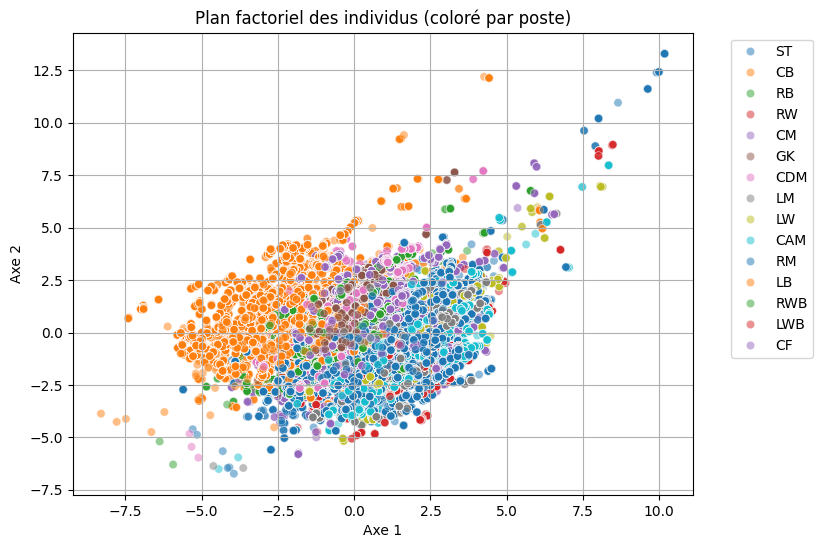

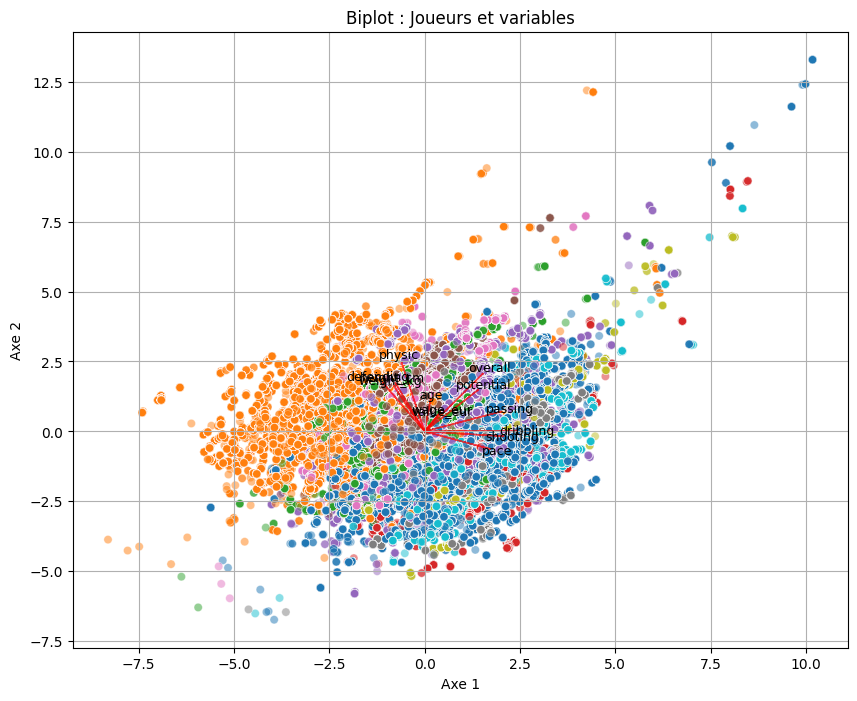

In [ ]:
# Projection des données sur les 2 premiers axes
scores_2D = pca_2.transform(data_acp_scaled)
scores_df = pd.DataFrame(scores_2D, columns=["Axis1", "Axis2"], index=data_acp_scaled.index)

female_players["positions_list"] = female_players["player_positions"].apply(
    lambda x: [pos.strip() for pos in x.split(",")]
)

# Extraire la position principale (par exemple, la première de la liste)
female_players["main_position"] = female_players["positions_list"].apply(lambda x: x[0])

plt.figure(figsize=(8,6))
sns.scatterplot(x=scores_df["Axis1"], y=scores_df["Axis2"],
                hue=female_players["main_position"],  # ou tout autre variable catégorielle
                palette="tab10", alpha=0.5)
plt.xlabel("Axe 1")
plt.ylabel("Axe 2")
plt.title("Plan factoriel des individus (coloré par poste)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True)
plt.show()


# --- Biplot (combinaison individus + variables) ---
# On réutilise la projection des individus et on superpose les flèches des variables
plt.figure(figsize=(10,8))
sns.scatterplot(x=scores_df["Axis1"], y=scores_df["Axis2"],
                hue=female_players["main_position"],  # variable catégorielle
                palette="tab10", alpha=0.5, legend=False)
plt.xlabel("Axe 1")
plt.ylabel("Axe 2")
plt.title("Biplot : Joueurs et variables")

# On multiplie les loadings par un facteur pour mieux visualiser
scaling_factor = 5
for i, var in enumerate(data_acp_scaled.columns):
    if var in top_vars:
        x = loadings[i,0]
        y = loadings[i,1]
        plt.arrow(0, 0, x*scaling_factor, y*scaling_factor,
                  color='red', alpha=0.7, head_width=0.03, length_includes_head=True)
        plt.text(x*scaling_factor*1.1, y*scaling_factor*1.1, var,
                 color='black', fontsize=9, ha='center', va='center')
plt.grid(True)
plt.show()

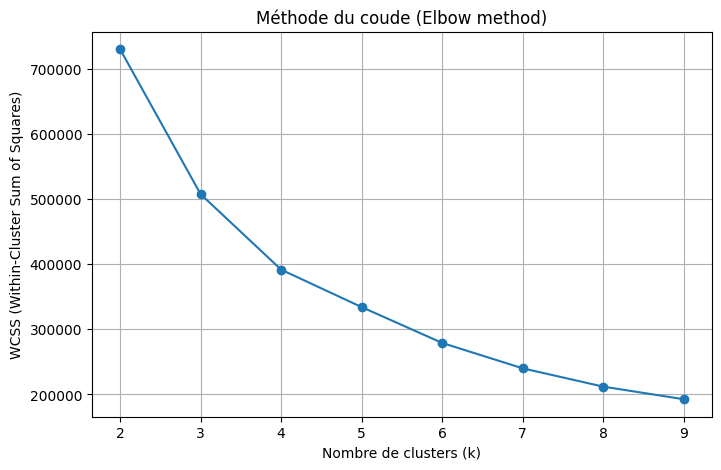

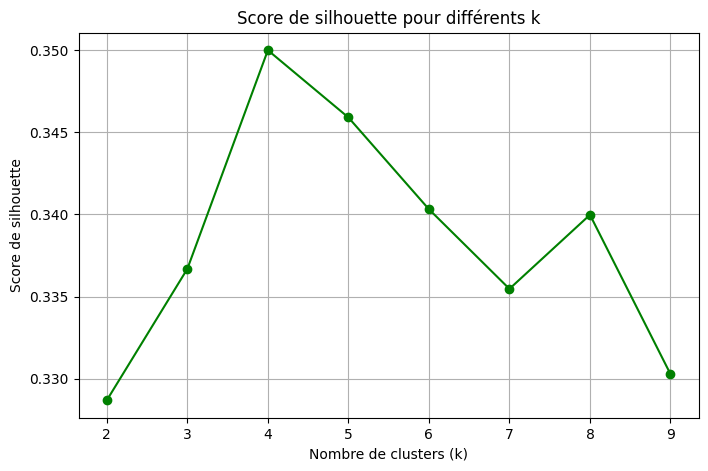

Nombre optimal de clusters (selon le score silhouette) : 4


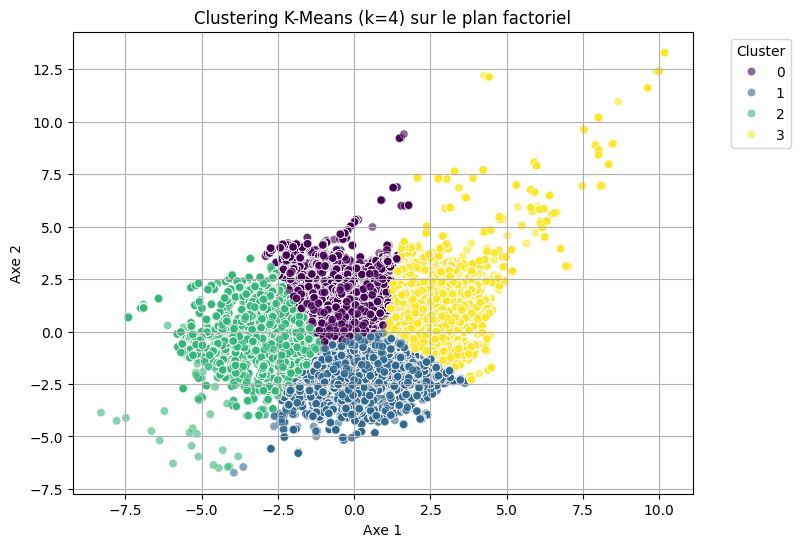

In [25]:
# Méthode du coude
wcss = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scores_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o')
plt.title("Méthode du coude (Elbow method)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()

# Score de silhouette
silhouette_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scores_df)
    sil_score = silhouette_score(scores_df, labels)
    silhouette_scores.append(sil_score)

plt.figure(figsize=(8,5))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title("Score de silhouette pour différents k")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de silhouette")
plt.grid(True)
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Nombre optimal de clusters (selon le score silhouette) : {optimal_k}")

# Finalement, on applique KMeans avec le k optimal
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(scores_df)
scores_df["cluster"] = cluster_labels

# Visualisation du clustering
plt.figure(figsize=(8,6))
sns.scatterplot(x="Axis1", y="Axis2", data=scores_df,
                hue="cluster", palette="viridis", alpha=0.6)
plt.title(f"Clustering K-Means (k={optimal_k}) sur le plan factoriel")
plt.xlabel("Axe 1")
plt.ylabel("Axe 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title="Cluster")
plt.grid(True)
plt.show()

# 3. Décomposition en Valeurs Singulières (SVD) :

• *Décomposition* : 
  – Appliquer la **SVD** sur la matrice (joueurs × variables normalisées).
  – Observer les valeurs singulières pour voir combien d’axes dominent la variance.

• *Comparaison avec l’ACP* :
  – En données centrées, ACP et SVD sont mathématiquement reliées.
  – Vérifier la cohérence des premiers vecteurs singuliers avec les composantes principales.

### Décomposition SVD : $$X = U Σ V^T$$

In [26]:
# Convertir en array 
X = data_acp_scaled.values

In [27]:
X.shape

(181361, 13)

In [28]:
# Calcul de la SVD
U, S, Vt = np.linalg.svd(X, full_matrices=False)
V = Vt.T  # On récupère V en prenant la transposée de Vt

In [29]:
print("Dimensions de U :", U.shape)
print("Dimensions de Σ :", S.shape)
print("Dimensions de V :", V.shape)

Dimensions de U : (181361, 13)
Dimensions de Σ : (13,)
Dimensions de V : (13, 13)


In [30]:
print("\nValeurs singulières (Σ) :")
print(S)


Valeurs singulières (Σ) :
[813.03896685 693.2523318  566.74233756 503.27396223 458.4272194
 336.35598809 324.13317124 259.30391635 229.96916665 177.38097235
 173.13766529 145.77092106 102.0438392 ]


In [31]:
n_samples = X.shape[0]
eigenvalues_svd = S**2 / (n_samples - 1)
print("\nEigenvaleurs calculées via SVD :")
print(eigenvalues_svd)


Eigenvaleurs calculées via SVD :
[3.64486304 2.6499713  1.77104586 1.39658514 1.15877545 0.62381645
 0.57930256 0.37074615 0.29160685 0.17348924 0.16528811 0.11716565
 0.05741589]


In [32]:
n_samples = X.shape[0]
eigenvalues_svd = S**2 / (n_samples - 1)
print("\nEigenvaleurs calculées via SVD :")
print(eigenvalues_svd)


Eigenvaleurs calculées via SVD :
[3.64486304 2.6499713  1.77104586 1.39658514 1.15877545 0.62381645
 0.57930256 0.37074615 0.29160685 0.17348924 0.16528811 0.11716565
 0.05741589]


### Comparaison avec l'ACP


Eigenvaleurs issues de l'ACP :
[3.64486304 2.6499713  1.77104586 1.39658514 1.15877545 0.62381645
 0.57930256 0.37074615 0.29160685 0.17348924 0.16528811 0.11716565
 0.05741589]


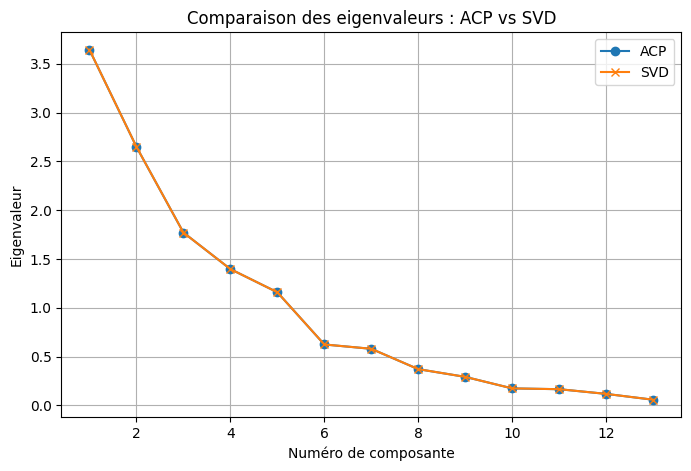

In [33]:
# Appliquer l'ACP sur les mêmes données (les données sont déjà centrées et réduites)
pca = PCA()
pca.fit(X)
eigenvalues_pca = pca.explained_variance_
print("\nEigenvaleurs issues de l'ACP :")
print(eigenvalues_pca)

# Comparaison graphique des eigenvaleurs
plt.figure(figsize=(8,5))
plt.plot(range(1, len(eigenvalues_pca)+1), eigenvalues_pca, marker='o', label="ACP")
plt.plot(range(1, len(eigenvalues_svd)+1), eigenvalues_svd, marker='x', label="SVD")
plt.xlabel("Numéro de composante")
plt.ylabel("Eigenvaleur")
plt.title("Comparaison des eigenvaleurs : ACP vs SVD")
plt.legend()
plt.grid(True);

In [34]:
# Les premiers vecteurs propres de l'ACP se trouvent dans pca.components_
print("\nPremière composante principale (vecteur propre ACP) :")
print(pca.components_[0])

# Le premier vecteur singulier droit obtenu via SVD est la première colonne de V
print("\nPremier vecteur singulier (colonne 1 de V) :")
print(V[:, 0])


Première composante principale (vecteur propre ACP) :
[ 0.30798475  0.28290724  0.08436755  0.08374077  0.03290025 -0.15485057
 -0.16335278  0.34706776  0.41715583  0.40561737  0.48605414 -0.22158046
 -0.12200917]

Premier vecteur singulier (colonne 1 de V) :
[-0.30798475 -0.28290724 -0.08436755 -0.08374077 -0.03290025  0.15485057
  0.16335278 -0.34706776 -0.41715583 -0.40561737 -0.48605414  0.22158046
  0.12200917]


# 4. Visualisation et interprétation :

• *Graphiques* : cercles de corrélation, biplots, scatter plots colorés par poste, heatmaps des
corrélations.

• *Interprétation des clusters* : quelles caractéristiques différencient un cluster d’attaquants
prolifiques d’un cluster de défenseurs expérimentés ?

• *Profil-type* : proposer un résumé (moyennes des stats) pour chaque cluster identifié, et relier
cela à des stratégies d’entraîneurs ou de recrutement.

### Graphiques

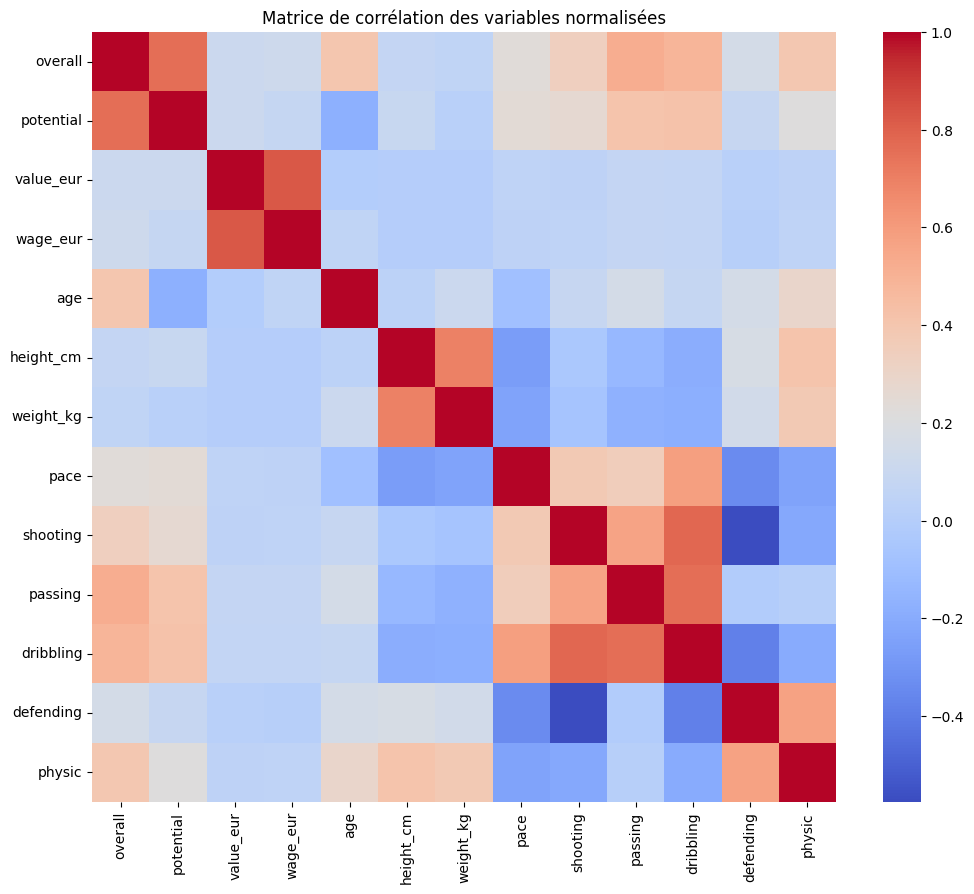

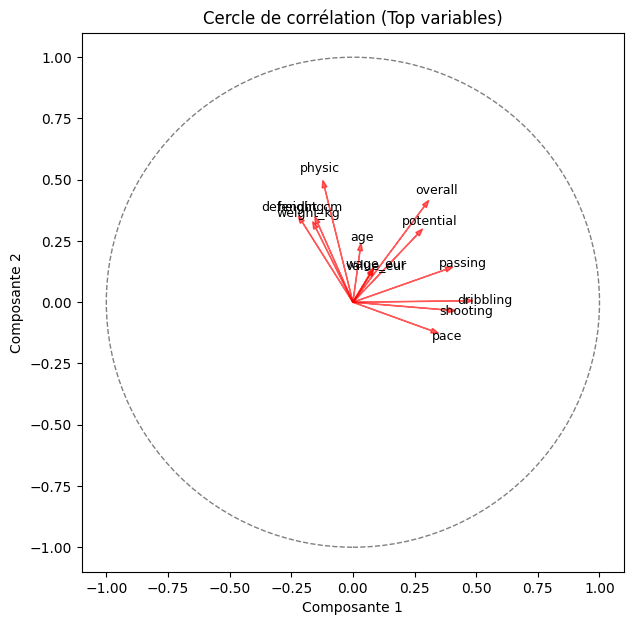

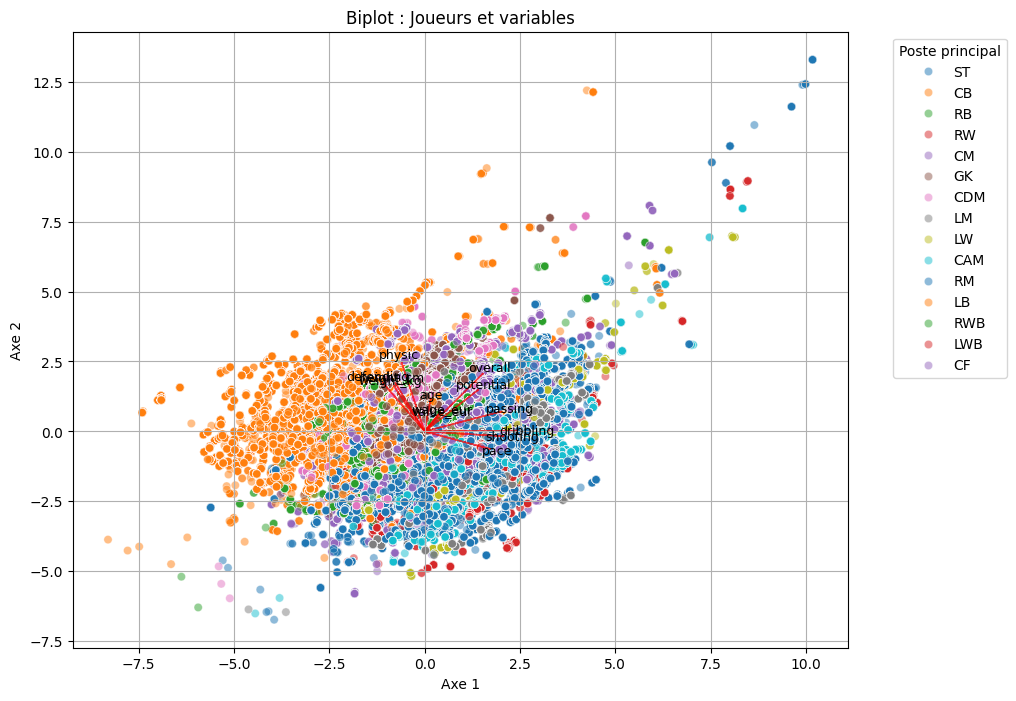

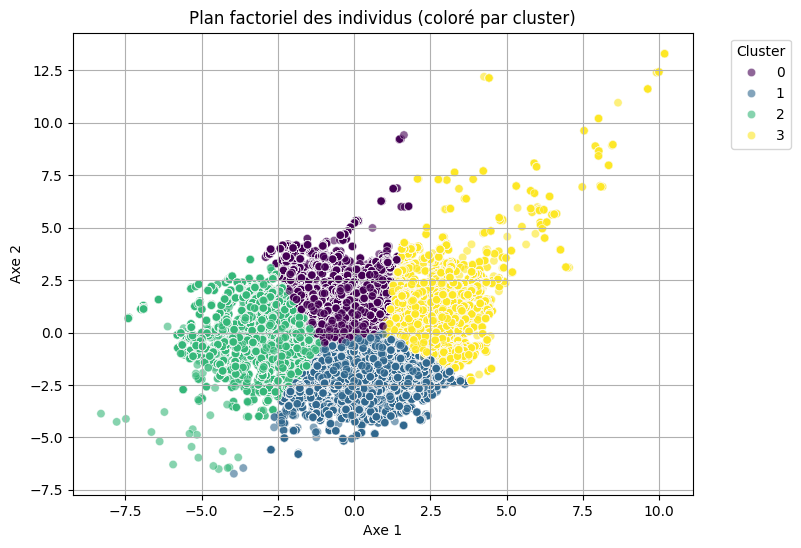

In [35]:
# Heatmap de la matrice de corrélation
plt.figure(figsize=(12,10))
corr_matrix = data_acp_scaled.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Matrice de corrélation des variables normalisées")
plt.show()

# Cercle de corrélation
# On récupère les loadings (les coefficients) sur les 2 premières composantes
loadings = pca.components_.T[:, :2]  # dimension (nb_variables, 2)
# On calcule les contributions (carré des loadings)
contrib = loadings**2
contrib_df = pd.DataFrame(contrib, index=data_acp_scaled.columns, columns=["Axis1", "Axis2"])

# On se fait un top 10 des variables qui pèsent le plus sur chaque axe et on fait l'union
top_vars_axis1 = set(contrib_df.sort_values("Axis1", ascending=False).head(10).index)
top_vars_axis2 = set(contrib_df.sort_values("Axis2", ascending=False).head(10).index)
top_vars = list(top_vars_axis1.union(top_vars_axis2))

plt.figure(figsize=(7,7))
# Dessin du cercle unité
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)
# Pour chaque variable, si elle fait partie du top, on trace sa flèche
for i, var in enumerate(data_acp_scaled.columns):
    if var in top_vars:
        x = loadings[i, 0]
        y = loadings[i, 1]
        plt.arrow(0, 0, x, y, color='red', alpha=0.6, head_width=0.02, length_includes_head=True)
        plt.text(x*1.1, y*1.1, var, fontsize=9, ha='center', va='center')
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("Cercle de corrélation (Top variables)")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(False)
plt.show()


# Biplot (individus + vecteurs des variables)
plt.figure(figsize=(10,8))
# On affiche la projection des joueurs (individus)
sns.scatterplot(x=scores_df["Axis1"], y=scores_df["Axis2"],
                hue=female_players["main_position"], palette="tab10", alpha=0.5)
# On ajoute les vecteurs des variables (on multiplie par un facteur pour que ça soit plus visible)
scaling_factor = 5
for i, var in enumerate(data_acp_scaled.columns):
    if var in top_vars:
        plt.arrow(0, 0, loadings[i, 0]*scaling_factor, loadings[i, 1]*scaling_factor,
                  color='red', alpha=0.7, head_width=0.03, length_includes_head=True)
        plt.text(loadings[i, 0]*scaling_factor*1.1, loadings[i, 1]*scaling_factor*1.1,
                 var, color='black', fontsize=9, ha='center', va='center')
plt.xlabel("Axe 1")
plt.ylabel("Axe 2")
plt.title("Biplot : Joueurs et variables")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title="Poste principal")
plt.grid(True)
plt.show()

# Scatter plot des individus coloré par cluster
plt.figure(figsize=(8,6))
sns.scatterplot(x=scores_df["Axis1"], y=scores_df["Axis2"],
                hue=scores_df["cluster"], palette="viridis", alpha=0.6)
plt.xlabel("Axe 1")
plt.ylabel("Axe 2")
plt.title("Plan factoriel des individus (coloré par cluster)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(True)
plt.show()

### Interprétation des clusters

In [36]:
# On ajoute la colonne cluster au DataFrame original
female_players_clustered = female_players.copy()
female_players_clustered["cluster"] = scores_df["cluster"]

# On calcule les moyennes pour chaque cluster pour nos variables d'intérêt
cluster_summary = female_players_clustered.groupby("cluster")[variables_acp].mean()
print("Résumé des moyennes par cluster (variables sélectionnées) :")
cluster_summary

Résumé des moyennes par cluster (variables sélectionnées) :


,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,pace,shooting,passing,dribbling,defending,physic
cluster,,,,,,,,,,,,,
0,77.707953,80.433717,6.682561e+06,702.482505,27.025853,172.273324,64.182564,71.763938,59.912126,67.530248,71.118769,70.232861,73.354831
1,73.096153,77.524152,6.441862e+06,697.198645,24.710229,164.397272,57.800098,76.003096,66.321172,65.006430,73.098139,44.289607,60.189629
2,72.079202,76.096541,6.391771e+06,695.587384,25.545147,170.489349,62.605516,65.223465,39.463355,52.945452,56.377906,70.325187,71.413317
3,83.019555,85.355288,7.847610e+06,721.636375,26.792784,167.868394,60.094715,80.539980,76.516106,76.386180,81.466709,52.518145,69.422860


### Profil-type et recommandations stratégiques

In [37]:
print("Profil-type de chaque cluster et pistes de stratégies :")

for c in cluster_summary.index:
    print(f"\n--- Cluster {c} ---")
    row = cluster_summary.loc[c]
    
    print("Moyennes des variables clés :")
    display(row[["overall", "potential", "age", "shooting", "defending", "pace", "physic"]])
    
    if row["shooting"] > row["defending"]:
        print("→ Ce cluster a un profil plus offensif (shooting > defending).")
        print("   Stratégie : Ce groupe de joueuses peut être priorisé pour les tactiques axées sur l'attaque,")
        print("               avec des entraînements orientés finition, appels en profondeur, etc.")
    else:
        print("→ Ce cluster a un profil plus défensif (defending >= shooting).")
        print("   Stratégie : Idéal pour renforcer le secteur défensif ou pour un jeu plus physique,")
        print("               en mettant l'accent sur les duels, la récupération de balle et l'organisation défensive.")
    
    print(f"   Âge moyen : {row['age']:.1f} ans, potentiel : {row['potential']:.2f}")
    print("   -> Des joueuses encore en progression ou déjà à maturité ?")
    
    print("   Conclusion : En fonction des objectifs (ex : marquer plus de buts, sécuriser la défense,")
    print("               développer des jeunes à fort potentiel), ce cluster offre un profil-type à cibler.\n")


Profil-type de chaque cluster et pistes de stratégies :

--- Cluster 0 ---
Moyennes des variables clés :


overall      77.707953
potential    80.433717
age          27.025853
shooting     59.912126
defending    70.232861
pace         71.763938
physic       73.354831
Name: 0, dtype: float64

→ Ce cluster a un profil plus défensif (defending >= shooting).
   Stratégie : Idéal pour renforcer le secteur défensif ou pour un jeu plus physique,
               en mettant l'accent sur les duels, la récupération de balle et l'organisation défensive.
   Âge moyen : 27.0 ans, potentiel : 80.43
   -> Des joueuses encore en progression ou déjà à maturité ?
   Conclusion : En fonction des objectifs (ex : marquer plus de buts, sécuriser la défense,
               développer des jeunes à fort potentiel), ce cluster offre un profil-type à cibler.


--- Cluster 1 ---
Moyennes des variables clés :


overall      73.096153
potential    77.524152
age          24.710229
shooting     66.321172
defending    44.289607
pace         76.003096
physic       60.189629
Name: 1, dtype: float64

→ Ce cluster a un profil plus offensif (shooting > defending).
   Stratégie : Ce groupe de joueuses peut être priorisé pour les tactiques axées sur l'attaque,
               avec des entraînements orientés finition, appels en profondeur, etc.
   Âge moyen : 24.7 ans, potentiel : 77.52
   -> Des joueuses encore en progression ou déjà à maturité ?
   Conclusion : En fonction des objectifs (ex : marquer plus de buts, sécuriser la défense,
               développer des jeunes à fort potentiel), ce cluster offre un profil-type à cibler.


--- Cluster 2 ---
Moyennes des variables clés :


overall      72.079202
potential    76.096541
age          25.545147
shooting     39.463355
defending    70.325187
pace         65.223465
physic       71.413317
Name: 2, dtype: float64

→ Ce cluster a un profil plus défensif (defending >= shooting).
   Stratégie : Idéal pour renforcer le secteur défensif ou pour un jeu plus physique,
               en mettant l'accent sur les duels, la récupération de balle et l'organisation défensive.
   Âge moyen : 25.5 ans, potentiel : 76.10
   -> Des joueuses encore en progression ou déjà à maturité ?
   Conclusion : En fonction des objectifs (ex : marquer plus de buts, sécuriser la défense,
               développer des jeunes à fort potentiel), ce cluster offre un profil-type à cibler.


--- Cluster 3 ---
Moyennes des variables clés :


overall      83.019555
potential    85.355288
age          26.792784
shooting     76.516106
defending    52.518145
pace         80.539980
physic       69.422860
Name: 3, dtype: float64

→ Ce cluster a un profil plus offensif (shooting > defending).
   Stratégie : Ce groupe de joueuses peut être priorisé pour les tactiques axées sur l'attaque,
               avec des entraînements orientés finition, appels en profondeur, etc.
   Âge moyen : 26.8 ans, potentiel : 85.36
   -> Des joueuses encore en progression ou déjà à maturité ?
   Conclusion : En fonction des objectifs (ex : marquer plus de buts, sécuriser la défense,
               développer des jeunes à fort potentiel), ce cluster offre un profil-type à cibler.

